# Baseline runs of all 4 optimizers

This document summarizes the results from running 4 optimizers with default settings:

* `lbfgs`: 
* `multi-start-lbfgs`
* `sa-automala`
* `pt-automala`

In [143]:
import json
import pandas as pd
import numpy as np
from pathlib import Path

In [144]:
def load_and_analyze_success_rates(json_path):
    """
    Load success rate data and compute augmented statistics for each trio.
    """
    with open(json_path, 'r') as f:
        data = json.load(f)
    
    results = []
    
    for trio_name, trio_data in data.items():
        if trio_data is None:
            # Skip trios that failed to compile or timed out
            continue
            
        sample_data = trio_data['sampleData']
        
        # Basic stats from trio_data
        samples = trio_data['samples']
        successes = trio_data['successes']
        bad_minima = trio_data['badMinima']
        failures = trio_data['failures']
        total_errors = bad_minima + failures

        assert total_errors + successes == samples
        
        # Compute augmented statistics from sample data
        if sample_data:
            # Average number of steps
            avg_steps = np.mean([s['steps'] for s in sample_data])
            
            # Mean of step time means
            step_time_means = [s['stepTimeMean'] for s in sample_data]
            mean_step_time = np.mean(step_time_means)
            
            # Average objective values (handling nulls)
            objective_values = [s['objectiveSum'] for s in sample_data if s['objectiveSum'] is not None]
            avg_objective = np.mean(objective_values) if objective_values else None
            
            # Number of inputs (from finalInputs length, handling nulls)
            input_lengths = [len(s['finalInputs']) for s in sample_data if s['finalInputs'] is not None]
            num_inputs = input_lengths[0] if input_lengths else None  # Should be consistent across samples
            
            # Average constraint sum
            constraint_values = [s['constraintSum'] for s in sample_data if s['constraintSum'] is not None]
            avg_constraint = np.mean(constraint_values) if constraint_values else None
            
            # Success rate
            success_rate = successes / samples if samples > 0 else 0
            
        else:
            avg_steps = None
            mean_step_time = None
            avg_objective = None
            num_inputs = None
            avg_constraint = None
            success_rate = 0
        
        results.append({
            'trio_name': trio_name,
            'samples': samples,
            'successes': successes,
            'bad_minima': bad_minima,
            'failures': failures,
            'total_errors': total_errors,
            'success_rate': success_rate,
            'avg_steps': avg_steps,
            'mean_step_time': mean_step_time,
            'avg_objective': avg_objective,
            'avg_constraint': avg_constraint,
            'num_inputs': num_inputs
        })
    
    # Convert to DataFrame and sort by total errors (descending)
    df = pd.DataFrame(results)
    df = df.sort_values('total_errors', ascending=False)

    
    return df

In [145]:
def print_summary_statistics(df, data_path):
    print("\n=== Summary Statistics ===")
    # Calculate total runtime across all experiments
    total_runtime = 0
    success_data = json.load(open(data_path))
    for trio_name, data in success_data.items():
        if 'sampleData' in data:
            for sample in data['sampleData']:
                if 'time' in sample:
                    total_runtime += sample['time']
    
    print(f"Total experiment runtime: {total_runtime/1000:.2f} seconds")
    print(f"Total trios analyzed: {len(df)}")
    print(f"Trios with no errors: {len(df[df['total_errors'] == 0])}")
    print(f"Trios with only bad minima: {len(df[(df['bad_minima'] > 0) & (df['failures'] == 0)])}")
    print(f"Trios with failures: {len(df[df['failures'] > 0])}")
    
    print("\n=== All Problematic Trios ===")
    display(df[df['total_errors'] > 0])

In [146]:
# Load the LBFGS data
lbfgs_data_path = "../data/lbfgs/success-rates.json"
lbfgs_df = load_and_analyze_success_rates(lbfgs_data_path)

# Print summary statistics
print_summary_statistics(lbfgs_df, lbfgs_data_path)


=== Summary Statistics ===
Total experiment runtime: 542.41 seconds
Total trios analyzed: 188
Trios with no errors: 145
Trios with only bad minima: 33
Trios with failures: 10

=== All Problematic Trios ===


,trio_name,samples,successes,bad_minima,failures,total_errors,success_rate,avg_steps,mean_step_time,avg_objective,avg_constraint,num_inputs
17,array-models/insertionSort,10,0,10,0,10,0.000000,15.500000,1.102293,0.000000,1.478750e+02,1071.0
100,triangle-mesh-2d/diagrams/cotan-formula,10,0,10,0,10,0.000000,835.500000,0.364377,2644.569612,1.611333e+01,199.0
168,alloy-models/workstations,10,0,10,0,10,0.000000,2087.300000,0.596783,47190.468905,2.570000e+04,381.0
61,molecules/sulfuric-acid,10,0,10,0,10,0.000000,252.700000,0.372048,97963.443262,2.296266e+01,242.0
26,dinoshade/dinoshade,10,0,10,0,10,0.000000,12.000000,0.118886,0.000000,2.704806e+05,621.0
63,word-cloud/example,10,0,10,0,10,0.000000,1466.400000,0.490420,105786.884222,4.000000e+00,172.0
89,matrix-ops/tests/matrix-vector-right-multiplic...,10,0,10,0,10,0.000000,12.000000,0.077017,0.000000,3.079586e-01,121.0
1,set-theory-domain/tree-tree,10,0,10,0,10,0.000000,37.900000,0.189824,26133.378660,1.600000e+01,129.0
95,matrix-ops/tests/vector-vector-multiplication-...,10,0,10,0,10,0.000000,12.000000,0.074067,0.000000,2.160179e+01,112.0
18,exterior-algebra/vector-wedge,10,0,10,0,10,0.000000,20.000000,0.109154,0.000000,4.000000e+00,57.0


In [147]:
# Load the Multi-start LBFGS data
multi_start_lbfgs_data_path = "../data/multi-start-lbfgs/success-rates.json"
multi_start_lbfgs_df = load_and_analyze_success_rates(multi_start_lbfgs_data_path)

# Print summary statistics
print_summary_statistics(multi_start_lbfgs_df, multi_start_lbfgs_data_path)


=== Summary Statistics ===
Total experiment runtime: 1388.43 seconds
Total trios analyzed: 188
Trios with no errors: 161
Trios with only bad minima: 27
Trios with failures: 0

=== All Problematic Trios ===


,trio_name,samples,successes,bad_minima,failures,total_errors,success_rate,avg_steps,mean_step_time,avg_objective,avg_constraint,num_inputs
26,dinoshade/dinoshade,10,0,10,0,10,0.0,6.000000,3.102458,0.000000,270480.611498,621.0
61,molecules/sulfuric-acid,10,0,10,0,10,0.0,472.900000,2.997553,95875.579278,22.962662,242.0
18,exterior-algebra/vector-wedge,10,0,10,0,10,0.0,20.400000,1.142286,0.000000,4.000000,57.0
17,array-models/insertionSort,10,0,10,0,10,0.0,10.000000,14.022078,0.000000,147.875000,1071.0
16,molecules/nitricacid-lewis,10,0,10,0,10,0.0,321.800000,2.453578,121926.288106,20.096928,188.0
89,matrix-ops/tests/matrix-vector-right-multiplic...,10,0,10,0,10,0.0,6.000000,0.928827,0.000000,0.307959,121.0
63,word-cloud/example,10,0,10,0,10,0.0,265.200000,5.288513,57151.434119,4.000000,172.0
106,timeline/penrose,10,0,10,0,10,0.0,36.800000,9.358932,0.000000,314.448638,371.0
179,alloy-models/icicle-plot-file-system,10,0,10,0,10,0.0,26.800000,3.354192,0.000000,0.166667,158.0
101,triangle-mesh-2d/diagrams/concyclic-pair,10,0,10,0,10,0.0,813.300000,2.088888,5531.186004,16.000000,151.0


In [148]:
# Load the Simulated Annealing Automala data
sa_automala_data_path = "../data/sa-automala/success-rates.json"
sa_automala_df = load_and_analyze_success_rates(sa_automala_data_path)

# Print summary statistics
print_summary_statistics(sa_automala_df, sa_automala_data_path)


=== Summary Statistics ===
Total experiment runtime: 2686.56 seconds
Total trios analyzed: 188
Trios with no errors: 109
Trios with only bad minima: 79
Trios with failures: 0

=== All Problematic Trios ===


,trio_name,samples,successes,bad_minima,failures,total_errors,success_rate,avg_steps,mean_step_time,avg_objective,avg_constraint,num_inputs
187,set-potatoes/non-surjection-not-epimorphism,10,0,10,0,10,0.000000,918.0,0.464270,4.753887e+05,9.734004e+01,334.0
68,persistent-homology/persistent-homology,10,0,10,0,10,0.000000,918.0,1.451954,2.465661e+04,1.178808e+06,704.0
167,alloy-models/river-crossing,10,0,10,0,10,0.000000,918.0,0.059325,3.335786e+05,2.401402e-01,47.0
165,alloy-models/message-passing,10,0,10,0,10,0.000000,918.0,1.115641,1.225507e+07,1.018609e+04,308.0
163,spectral-graphs/examples/periodic-hexagonal-la...,10,0,10,0,10,0.000000,918.0,1.028013,4.518568e+06,2.544921e+01,1274.0
...,...,...,...,...,...,...,...,...,...,...,...,...
113,curve-examples/blobs,1,0,1,0,1,0.000000,1836.0,4.931050,0.000000e+00,1.204163e+05,724.0
115,geometric-queries/ray-intersect/test-group,1,0,1,0,1,0.000000,918.0,30.669780,0.000000e+00,4.456457e+11,1744.0
31,graph-domain/textbook/sec1/fig7,3,2,1,0,1,0.666667,2754.0,3.525371,7.245183e+04,7.362781e+03,86.0
51,graph-domain/textbook/sec2/fig14,2,1,1,0,1,0.500000,1836.0,8.001200,-4.611772e+02,7.711537e+00,160.0


In [149]:
# Load the Parallel Tempering Automala data
pt_automala_data_path = "../data/pt-automala/success-rates.json"
pt_automala_df = load_and_analyze_success_rates(pt_automala_data_path)

# Print summary statistics
print_summary_statistics(pt_automala_df, pt_automala_data_path)


=== Summary Statistics ===
Total experiment runtime: 1353.35 seconds
Total trios analyzed: 188
Trios with no errors: 167
Trios with only bad minima: 20
Trios with failures: 1

=== All Problematic Trios ===


,trio_name,samples,successes,bad_minima,failures,total_errors,success_rate,avg_steps,mean_step_time,avg_objective,avg_constraint,num_inputs
104,triangle-mesh-2d/diagrams/triangle-centers,10,0,10,0,10,0.0,202.7,2.373929,2.613316,16.080000,125.0
1,set-theory-domain/tree-tree,10,0,10,0,10,0.0,101.6,1.231636,26106.070447,16.000000,129.0
17,array-models/insertionSort,10,0,10,0,10,0.0,100.9,10.903498,0.000000,147.875000,1071.0
89,matrix-ops/tests/matrix-vector-right-multiplic...,10,0,10,0,10,0.0,100.0,24.275641,0.000000,0.307959,121.0
106,timeline/penrose,10,0,10,0,10,0.0,208.8,10.351438,0.000000,431.776715,371.0
103,triangle-mesh-2d/diagrams/relative-orientation,10,0,10,0,10,0.0,203.2,3.074691,3.590916,16.166165,115.0
18,exterior-algebra/vector-wedge,10,0,10,0,10,0.0,101.8,1.338665,0.000000,4.000000,57.0
95,matrix-ops/tests/vector-vector-multiplication-...,10,0,10,0,10,0.0,100.0,22.481346,0.000000,21.601790,112.0
96,matrix-ops/tests/vector-vector-outerproduct,10,0,10,0,10,0.0,100.0,24.420478,0.000000,39.168584,121.0
102,triangle-mesh-2d/diagrams/halfedge-mesh,10,0,10,0,10,0.0,201.3,3.510367,0.000000,16.000000,111.0


# What trios do all methods struggle with?

In [150]:
# Find trios that have non-100% success rate across all methods
def find_struggling_trios():
    # Create a combined dataframe with success rates from all methods
    methods_data = [
        (lbfgs_df, 'LBFGS'),
        (multi_start_lbfgs_df, 'Multi-start LBFGS'),
        (sa_automala_df, 'SA Automala'),
        (pt_automala_df, 'PT Automala')
    ]
    
    # Start with the first method's data
    combined_df = methods_data[0][0][['trio_name', 'success_rate']].copy()
    combined_df = combined_df.rename(columns={'success_rate': f'{methods_data[0][1]}_success_rate'})
    
    # Join with other methods
    for df, method_name in methods_data[1:]:
        method_df = df[['trio_name', 'success_rate']].copy()
        method_df = method_df.rename(columns={'success_rate': f'{method_name}_success_rate'})
        combined_df = combined_df.merge(method_df, on='trio_name', how='outer')
    
    # Convert success rates to failure rates
    success_cols = [col for col in combined_df.columns if col.endswith('_success_rate')]
    has_failures = combined_df[
        (combined_df[success_cols] < 1.0).any(axis=1)
    ].copy()
    
    # Count methods with failures and calculate average failure rate
    has_failures['methods_with_failures'] = (has_failures[success_cols] < 1.0).sum(axis=1)
    
    # Sort by methods with failures (descending) then by average failure rate (descending)
    has_failures = has_failures.sort_values(['methods_with_failures'], 
                                          ascending=[False])
    
    return has_failures

# Find and display struggling trios
struggling_trios = find_struggling_trios()

print("Trios with non-100% success rates across optimization methods:")
print("=" * 80)
print(f"Total trios with failures: {len(struggling_trios)}")
print()

# Display the table with formatting
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

# Display the table without styling (since jinja2 is not available)
display_cols = ['trio_name', 'LBFGS_success_rate', 'Multi-start LBFGS_success_rate', 
               'SA Automala_success_rate', 'PT Automala_success_rate', 'methods_with_failures']

display(struggling_trios[display_cols])

print()

# Show summary of trios that fail across all methods
all_methods_fail = struggling_trios[struggling_trios['methods_with_failures'] == 4]
print(f"\nTrios that struggle with ALL 4 methods: {len(all_methods_fail)}")
        
# Display trios where all methods fail as a dataframe
if len(all_methods_fail) > 0:
    print(f"\nTrios where ALL 4 methods have non-100% success rates:")
    print("-" * 60)
    display(all_methods_fail[display_cols])


Trios with non-100% success rates across optimization methods:
Total trios with failures: 99



,trio_name,LBFGS_success_rate,Multi-start LBFGS_success_rate,SA Automala_success_rate,PT Automala_success_rate,methods_with_failures
187,word-cloud/example,0.0,0.0,0.0,0.0,4
175,triangle-mesh-2d/diagrams/triangle-centers,0.0,0.0,0.0,0.0,4
174,triangle-mesh-2d/diagrams/relative-orientation,0.0,0.0,0.0,0.0,4
173,triangle-mesh-2d/diagrams/halfedge-mesh,0.0,0.0,0.0,0.0,4
172,triangle-mesh-2d/diagrams/cotan-formula,0.0,0.0,0.0,0.0,4
...,...,...,...,...,...,...
72,graph-domain/textbook/sec2/fig14,1.0,1.0,0.5,1.0,1
74,graph-domain/textbook/sec2/fig3,1.0,1.0,1.0,0.0,1
75,graph-domain/textbook/sec2/fig4,1.0,1.0,1.0,0.0,1
77,graph-domain/textbook/sec2/fig6,0.5,1.0,1.0,1.0,1




Trios that struggle with ALL 4 methods: 29

Trios where ALL 4 methods have non-100% success rates:
------------------------------------------------------------


,trio_name,LBFGS_success_rate,Multi-start LBFGS_success_rate,SA Automala_success_rate,PT Automala_success_rate,methods_with_failures
187,word-cloud/example,0.000000,0.0,0.000000,0.0,4
175,triangle-mesh-2d/diagrams/triangle-centers,0.000000,0.0,0.000000,0.0,4
174,triangle-mesh-2d/diagrams/relative-orientation,0.000000,0.0,0.000000,0.0,4
173,triangle-mesh-2d/diagrams/halfedge-mesh,0.000000,0.0,0.000000,0.0,4
172,triangle-mesh-2d/diagrams/cotan-formula,0.000000,0.0,0.000000,0.0,4
171,triangle-mesh-2d/diagrams/concyclic-pair,0.000000,0.0,0.000000,0.0,4
170,triangle-mesh-2d/diagrams/angle-equivalence,0.000000,0.0,0.000000,0.0,4
169,timeline/penrose,0.000000,0.0,0.000000,0.0,4
168,structural-formula/reactions/methane-combustion,0.000000,0.0,0.000000,0.0,4
166,stochastic-process/stochastic-process,0.100000,0.1,0.142857,0.0,4


In [151]:
# Get raw data for trios that fail across all methods
if len(all_methods_fail) > 0:
    print(f"\nDetailed raw data for trios that fail across ALL 4 methods:")
    print("=" * 80)
    
    methods_data = [
      (lbfgs_df, 'LBFGS'),
      (multi_start_lbfgs_df, 'Multi-start LBFGS'),
      (sa_automala_df, 'SA Automala'),
      (pt_automala_df, 'PT Automala')
    ]


    for idx, row in all_methods_fail.iterrows():
        trio_name = row['trio_name']
        print(f"\nTrio: {trio_name}")
        print("-" * 60)
        
        # Get data from each method's dataframe
        for df, method_name in methods_data:
            method_df = df[df['trio_name'] == trio_name].iloc[0]
            print(f"\n{method_name}:")
            print(f"  Success rate: {method_df['success_rate']:.3f}")
            print(f"  Samples: {method_df['samples']}")
            print(f"  Successes: {method_df['successes']}")
            print(f"  Bad minima: {method_df['bad_minima']}")
            print(f"  Failures: {method_df['failures']}")
        
        print("\n" + "="*60)





Detailed raw data for trios that fail across ALL 4 methods:

Trio: word-cloud/example
------------------------------------------------------------

LBFGS:
  Success rate: 0.000
  Samples: 10
  Successes: 0
  Bad minima: 10
  Failures: 0


KeyError: 'avg_wall_clock_time'

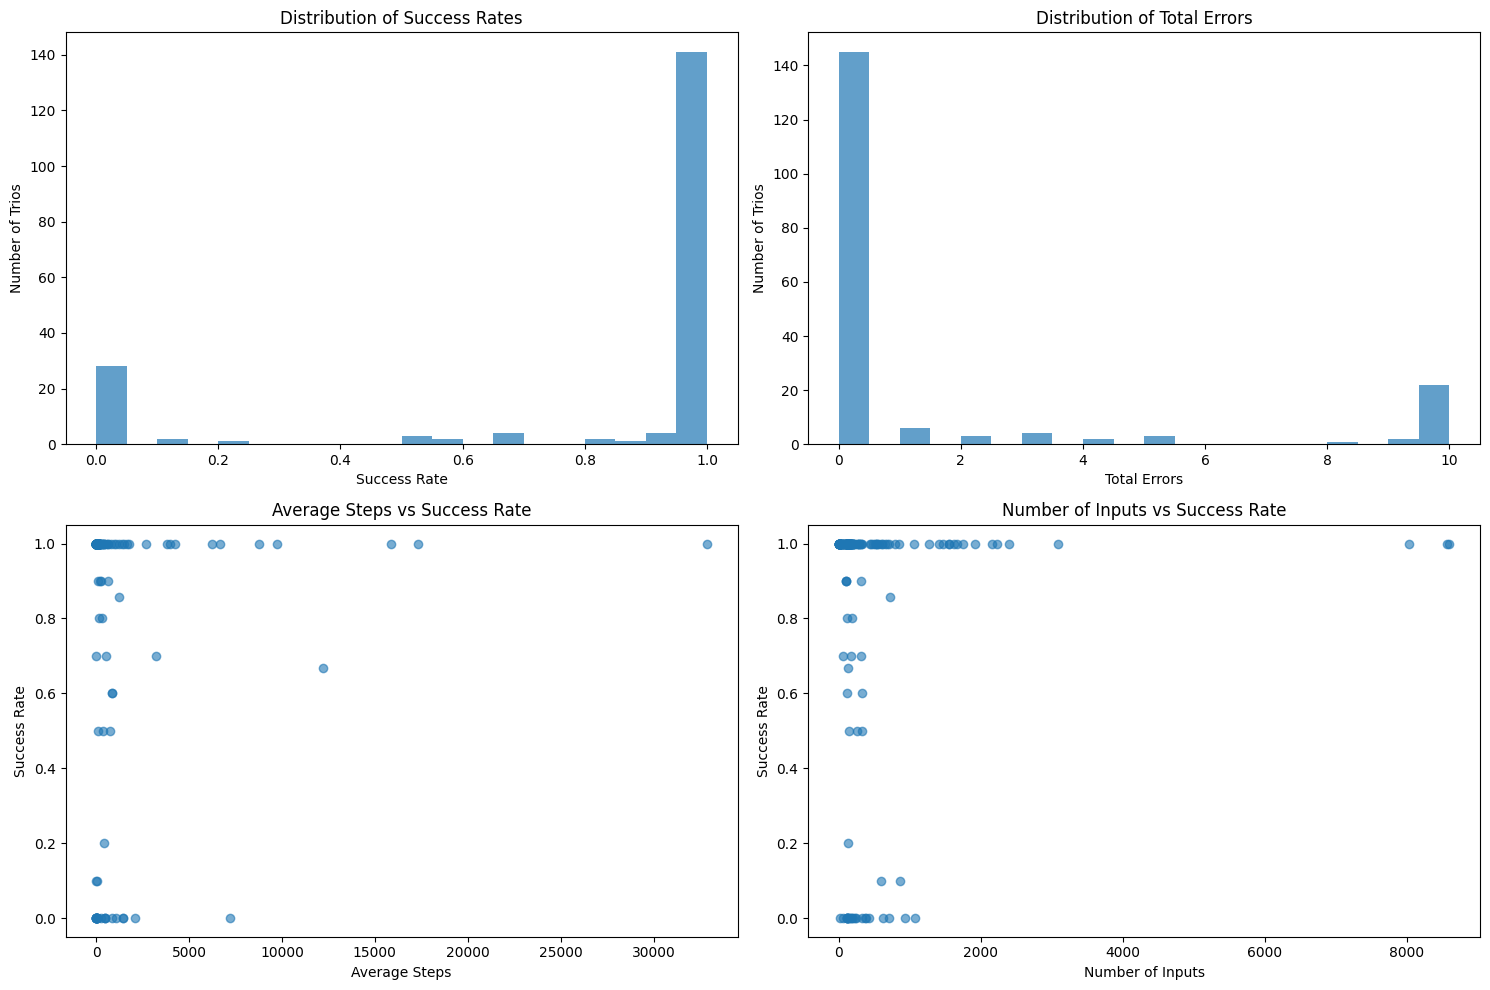

In [114]:
# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

if 'df' in locals():
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Success rate distribution
    axes[0, 0].hist(df['success_rate'], bins=20, alpha=0.7)
    axes[0, 0].set_xlabel('Success Rate')
    axes[0, 0].set_ylabel('Number of Trios')
    axes[0, 0].set_title('Distribution of Success Rates')
    
    # Total errors distribution
    axes[0, 1].hist(df['total_errors'], bins=20, alpha=0.7)
    axes[0, 1].set_xlabel('Total Errors')
    axes[0, 1].set_ylabel('Number of Trios')
    axes[0, 1].set_title('Distribution of Total Errors')
    
    # Average steps vs success rate
    valid_steps = df.dropna(subset=['avg_steps'])
    axes[1, 0].scatter(valid_steps['avg_steps'], valid_steps['success_rate'], alpha=0.6)
    axes[1, 0].set_xlabel('Average Steps')
    axes[1, 0].set_ylabel('Success Rate')
    axes[1, 0].set_title('Average Steps vs Success Rate')
    
    # Number of inputs vs success rate
    valid_inputs = df.dropna(subset=['num_inputs'])
    axes[1, 1].scatter(valid_inputs['num_inputs'], valid_inputs['success_rate'], alpha=0.6)
    axes[1, 1].set_xlabel('Number of Inputs')
    axes[1, 1].set_ylabel('Success Rate')
    axes[1, 1].set_title('Number of Inputs vs Success Rate')
    
    plt.tight_layout()
    plt.show()